In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/florian/GitRepos/activeCell-ACDC
!ls

import json
import random as rd
import matplotlib.image as mpimg
import cv2
import wandb
import torch
import os
import logging
import pandas as pd
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer

from src.globals import *
from utils.visualization.show_image import show_image, plot_prediction
from utils.register_datasets import register_datasets, get_dataset_name
from utils.config_builder import get_config
from utils.notebook_utils import *
from utils.evaluation import SingleImageCOCOEvaluator
from utils.evaluation_accuracy import AccuracyEvaluator


from src.test import do_test
from src.active_learning.al_trainer import *
from src.active_learning.mc_dropout_sampler import *
from src.active_learning.tta_sampler import *


logger = setup_logger(output="./log/main.log",name="null_logger") 
logger.addHandler(logging.NullHandler())
logging.getLogger('detectron2').setLevel(logging.WARNING)
logging.getLogger('detectron2').addHandler(logging.NullHandler())

/home/florian/GitRepos/activeCell-ACDC
ac_acdc_env  experiments  notebooks	    README.md	      src
al_output    local	  output	    requirements.txt  utils
data	     log	  pipeline_configs  shell_scripts     wandb


In [2]:
dataset = ACDC_LARGE_CLS
test_dataset_name = dataset + "_test_slim"
config_name = "final_random_al"

model_path = "/home/florian/GitRepos/activeCell-ACDC/output"

In [3]:
register_datasets()
train_data = DatasetCatalog.get(get_dataset_name(
    dataset, DATASETS_DSPLITS[dataset][0]
))

test_data = DatasetCatalog.get(test_dataset_name)

registering acdc_large_cls dataset
registering chlamy_dataset dataset


In [4]:
wandb.init(
    project="activeCell-ACDC",
    name="",
    sync_tensorboard=True,
    mode="disabled",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [5]:
default_cfg = get_config(config_name)
cfg = default_cfg
cfg.OUTPUT_DIR = "./al_output/classes_acdc_large_al"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05#.4
#cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2
#cfg.TEST.DETECTIONS_PER_IMAGE = 50

In [6]:
model = load_model(cfg, os.path.join(model_path, "best_model.pth"))
#model = load_model(cfg, os.path.join(model_path, "last_model1200.pth"))


In [7]:
results = do_test(cfg, model=model, logger=logger)

/home/florian/GitRepos/activeCell-ACDC/ac_acdc_env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.922
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.456
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.463
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.095
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.484
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.564
 Average Recall     (AR) @[ IoU=0.50:0.

In [8]:
results

OrderedDict([('segm',
              OrderedDict([('AP', 84.6558849125421),
                           ('AP50', 92.79736054307897),
                           ('AP75', 89.20571742844452),
                           ('APs', 81.55536552714261),
                           ('APm', 89.78970163435926),
                           ('APl', 81.90452631204576),
                           ('AP-G1', 87.17361978282929),
                           ('AP-mother', 94.18967009681052),
                           ('AP-bud', 72.60436485798652)])),
             ('bbox',
              OrderedDict([('AP', 44.22152688541333),
                           ('AP50', 92.20861870271845),
                           ('AP75', 28.643592557812187),
                           ('APs', 45.60815450954714),
                           ('APm', 46.30443207932283),
                           ('APl', 22.830074597780253),
                           ('AP-G1', 47.116526754129104),
                           ('AP-mother', 47.538431868468

In [9]:
cfg_tmp = cfg
cfg_tmp.DATASETS.TEST = ("acdc_large_cls_train",)
train_results = do_test(cfg_tmp, model=model, logger=logger)
train_results

KeyboardInterrupt: 

In [12]:
evaluator = SingleImageCOCOEvaluator(test_dataset_name, cfg, False,output_dir="./" )
val_loader = build_detection_test_loader(cfg, test_dataset_name)

#Use the created predicted model in the previous step
res = inference_on_dataset(model, val_loader, evaluator)


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50

In [ ]:
res

{'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0': OrderedDict([('bbox',
               {'AP': 50.0,
                'AP50': 100.0,
                'AP75': 0.0,
                'APs': 50.0,
                'APm': nan,
                'APl': nan,
                'AP-G1': nan,
                'AP-mother': 50.0,
                'AP-bud': 50.0}),
              ('segm',
               {'AP': 100.0,
                'AP50': 100.0,
                'AP75': 100.0,
                'APs': 100.0,
                'APm': nan,
                'APl': nan,
                'AP-G1': nan,
                'AP-mother': 100.0,
                'AP-bud': 100.0})]),
 'TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_102': OrderedDict([('bbox',
               {'AP': 54.290429042904286,
                'AP50': 100.0,
                'AP75': 52.97029702970298,
                'APs': 55.28052805280528,
                'APm': nan,
                'APl': nan,
                'AP-G1': 60.0,
                'AP-mother

In [13]:
segm_ap_dict = [
    {
        "image_id": key,
        "segm_ap": res[key]["segm"]["AP"],
        "AP-G1": res[key]["segm"]["AP-G1"],
        "AP-mother": res[key]["segm"]["AP-mother"],
        "AP-bud": res[key]["segm"]["AP-bud"],
    } for key in res.keys()
]

In [14]:
df = pd.DataFrame.from_records(segm_ap_dict).sort_values("segm_ap")
df.head()

image_id    segm_ap      AP-G1  \
92                    acdc_data2_F016_pos_3_18  15.000000   0.000000   
120                   acdc_data2_F016_pos_3_93  40.798366  76.072607   
401                acdc_data3_20211029_pos_1_9  47.970297        NaN   
130  acdc_data2_kurt_306-3_0_20201028_pos_1_12  48.481848   0.000000   
276               acdc_data3_20210722_pos_2_21  48.706271  16.831683   

      AP-mother     AP-bud  
92    45.000000   0.000000  
120   45.841584   0.480905  
401   50.495050  45.445545  
130  100.000000  45.445545  
276   82.554455  46.732673

In [15]:
df.tail().values

array([['acdc_data3_20211029_pos_1_63', 100.0, 100.0, 100.0, 100.0],
       ['acdc_data3_20211029_pos_1_81', 100.0, 100.0, 100.0, 100.0],
       ['acdc_data3_20211029_pos_1_84', 100.0, 100.0, 100.0, 100.0],
       ['acdc_data2_F016_pos_3_42', 100.0, nan, 100.0, 100.0],
       ['TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0', 100.0, nan,
        100.0, 100.0]], dtype=object)

acdc_data2_F016_pos_3_18 segm_ap: 30.0


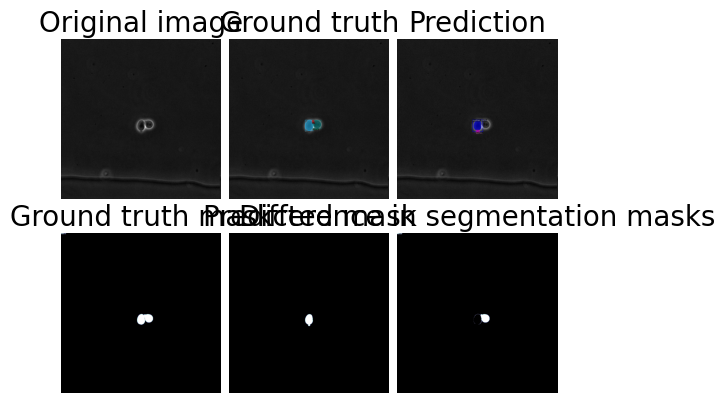

acdc_data2_F016_pos_3_93 segm_ap: 45.67624024307192


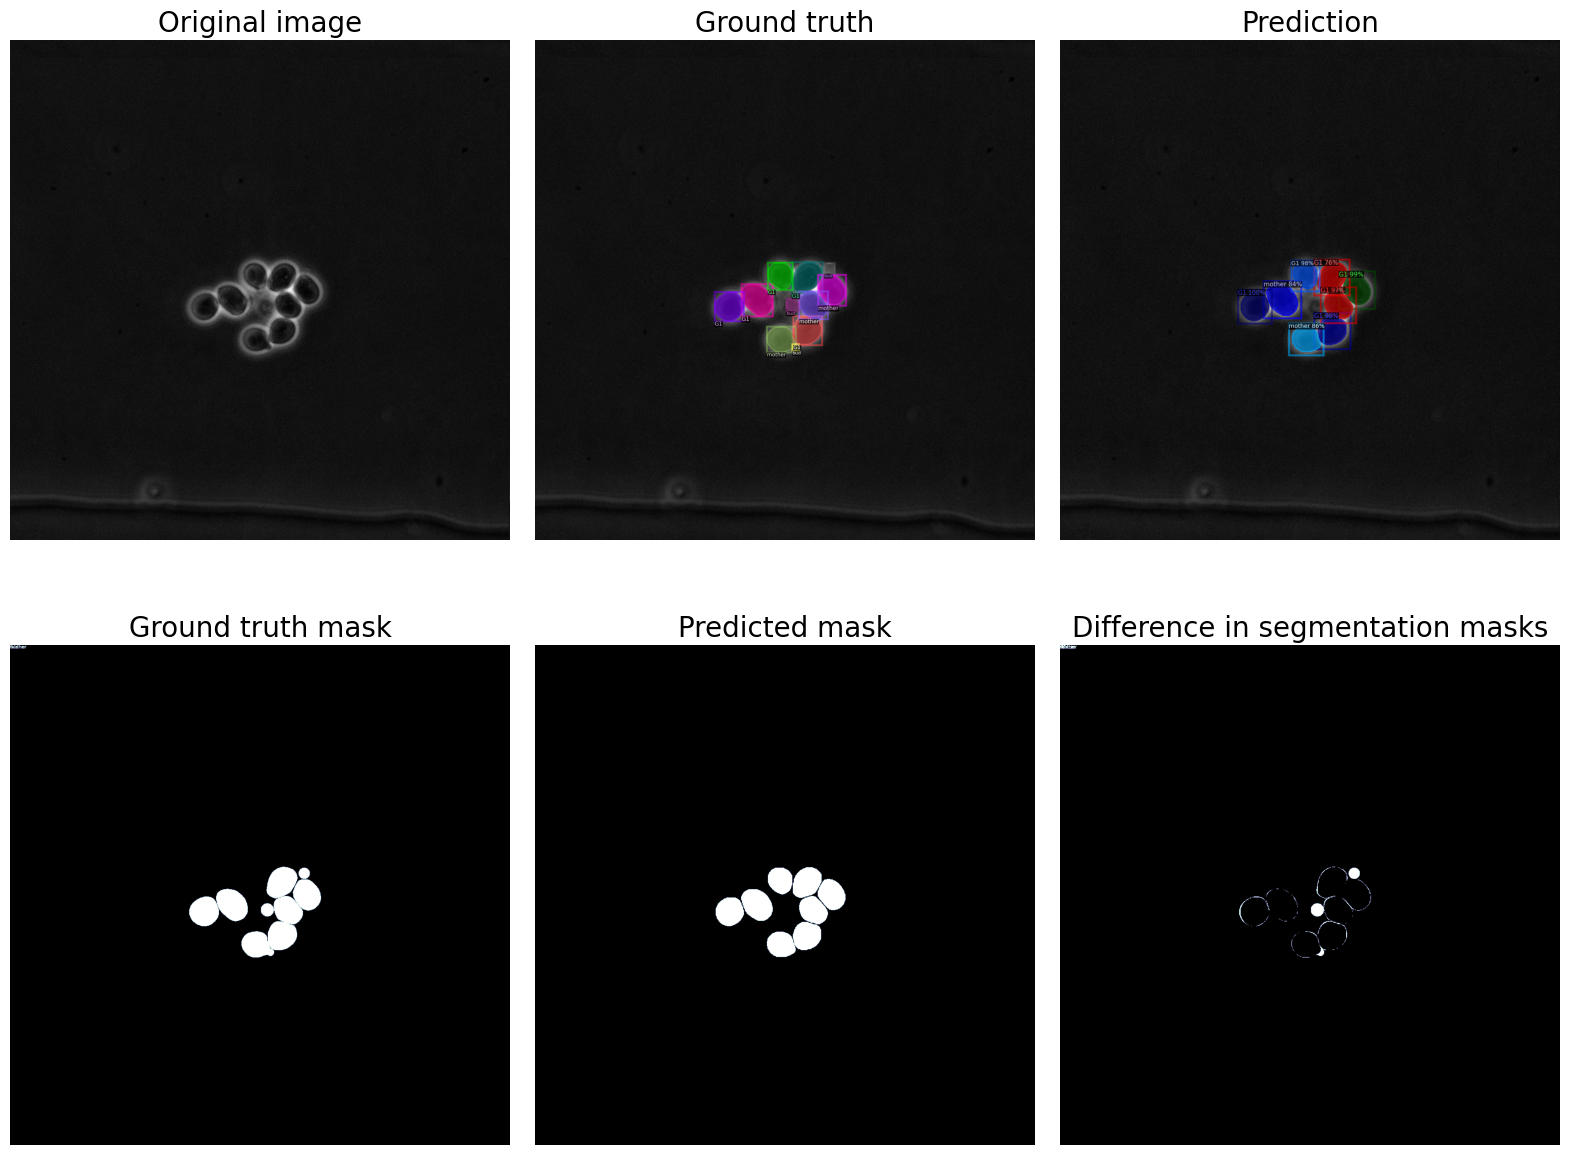

acdc_data2_F016_pos_3_90 segm_ap: 51.55940594059406


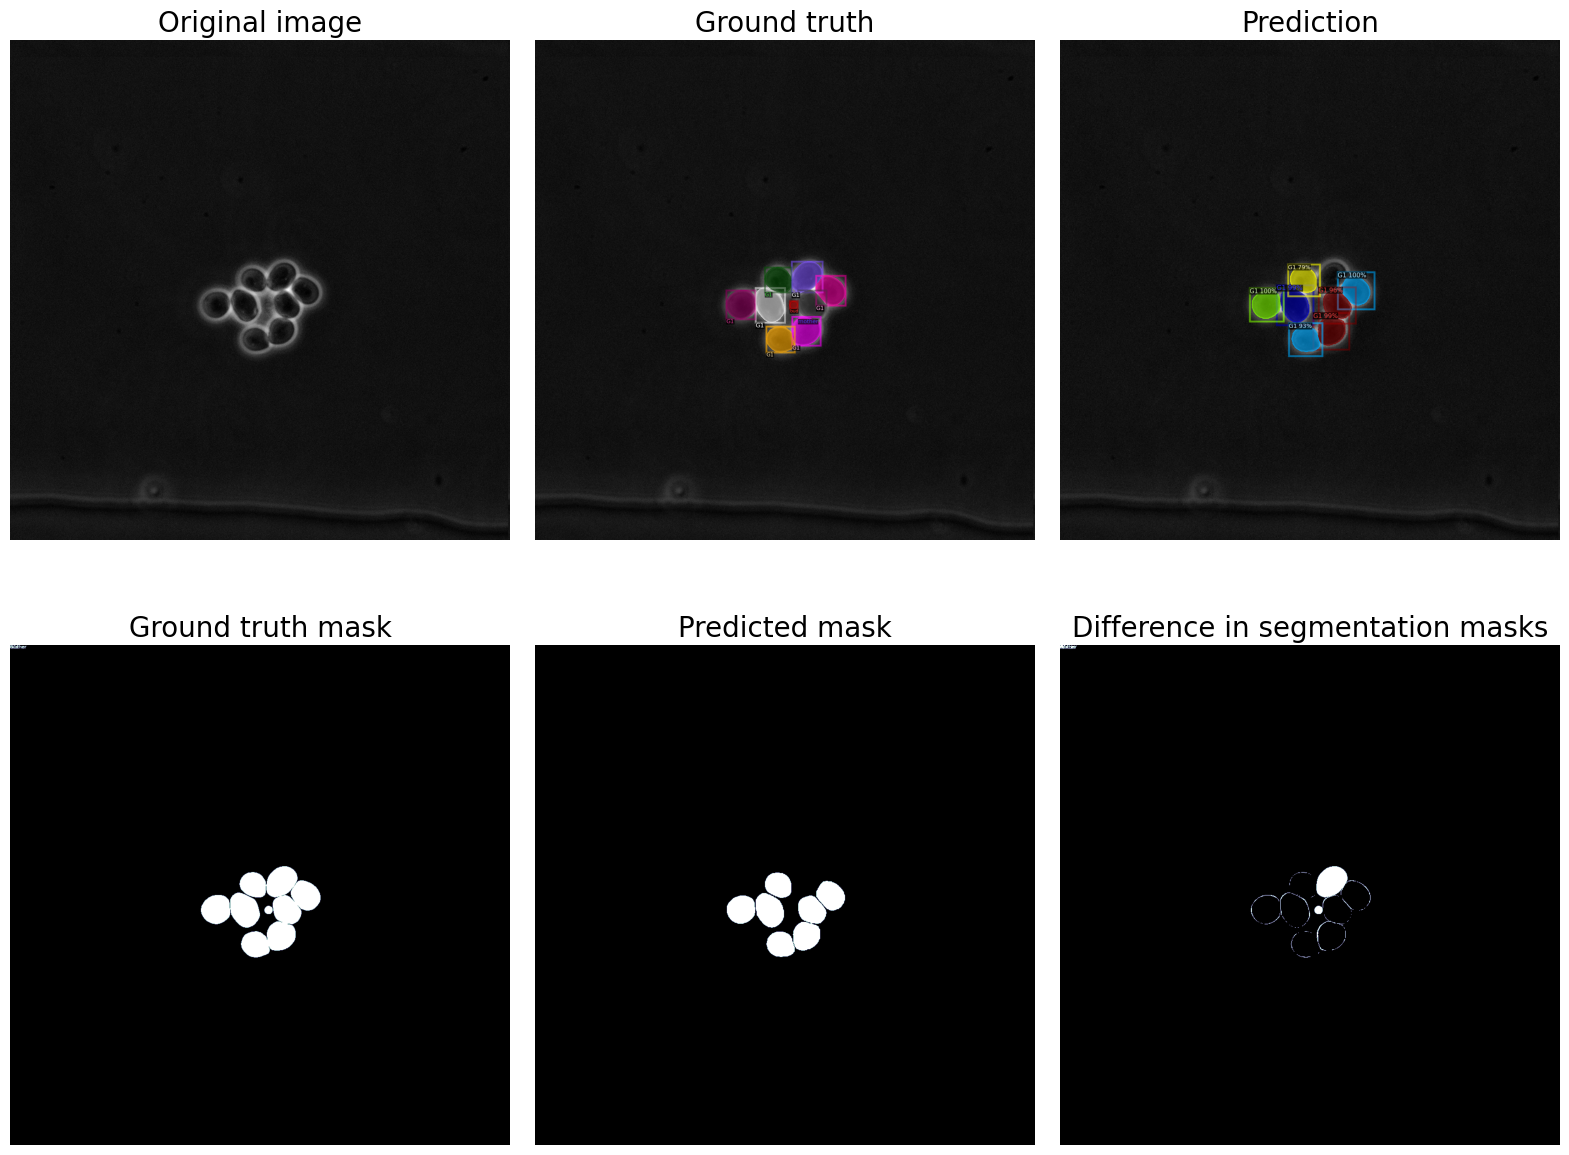

acdc_data2_F016_pos_3_96 segm_ap: 54.06715671567157


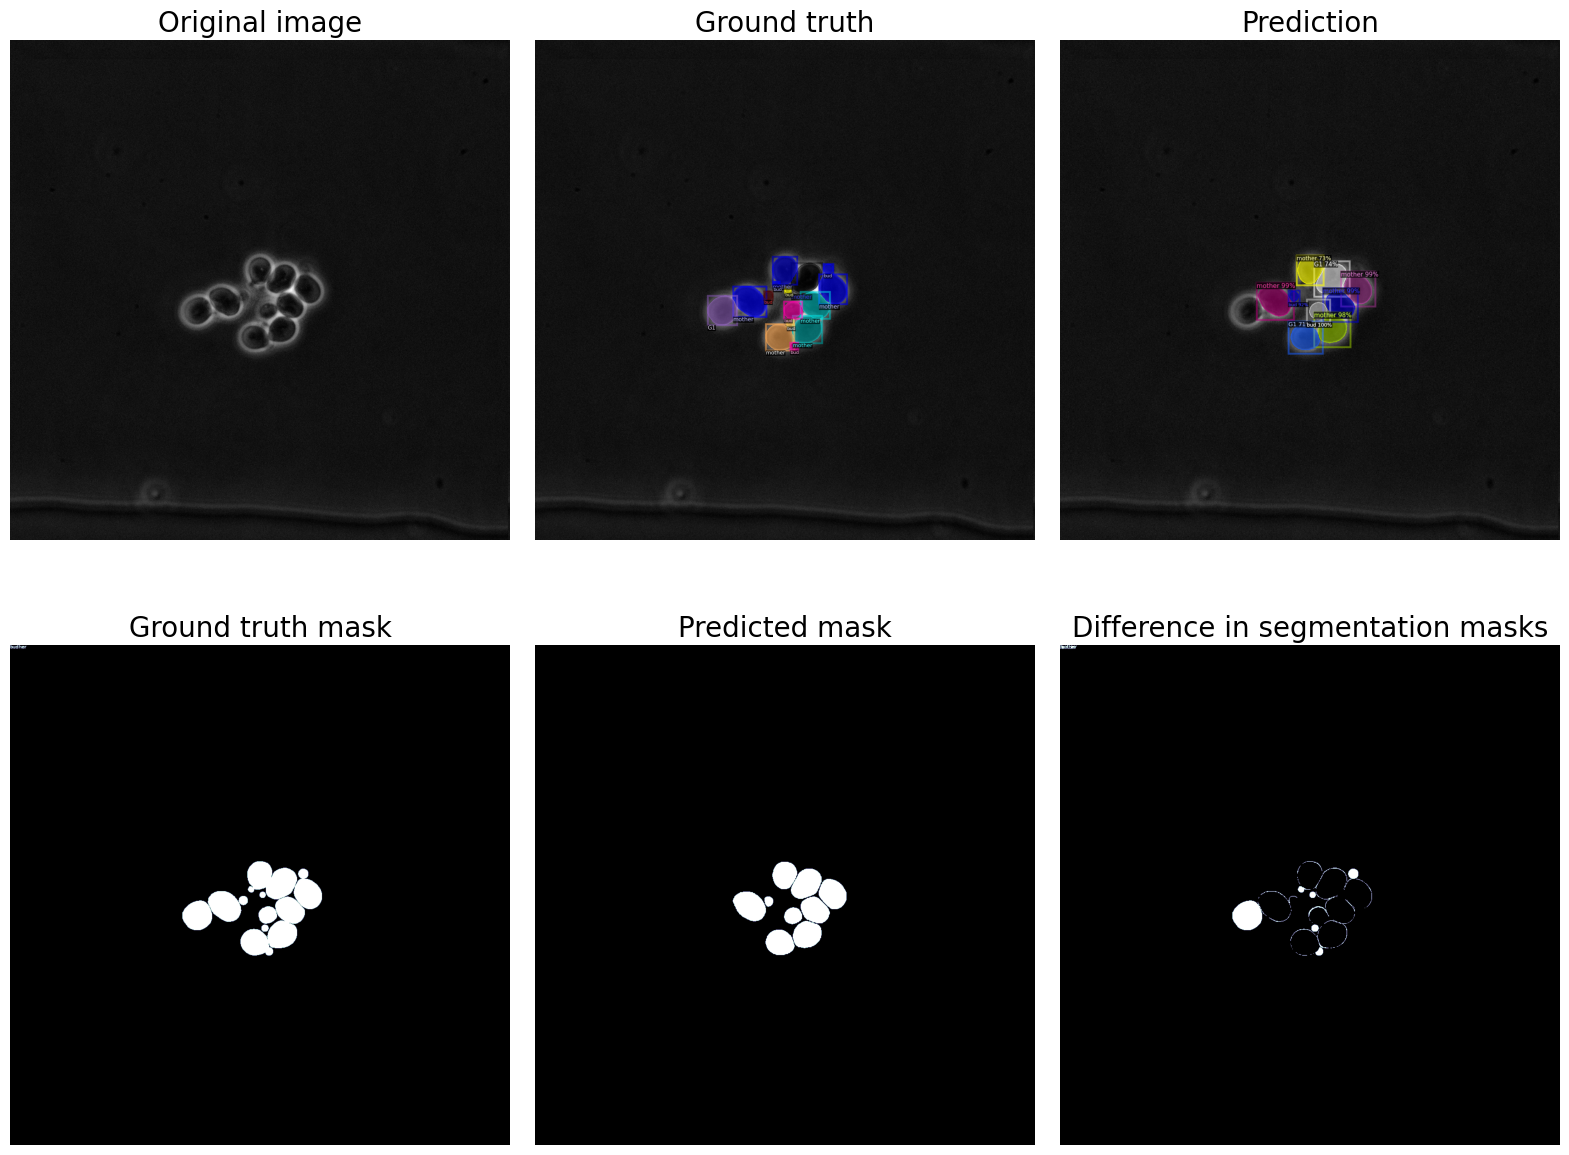

acdc_data2_F016_pos_3_60 segm_ap: 60.05830583058306


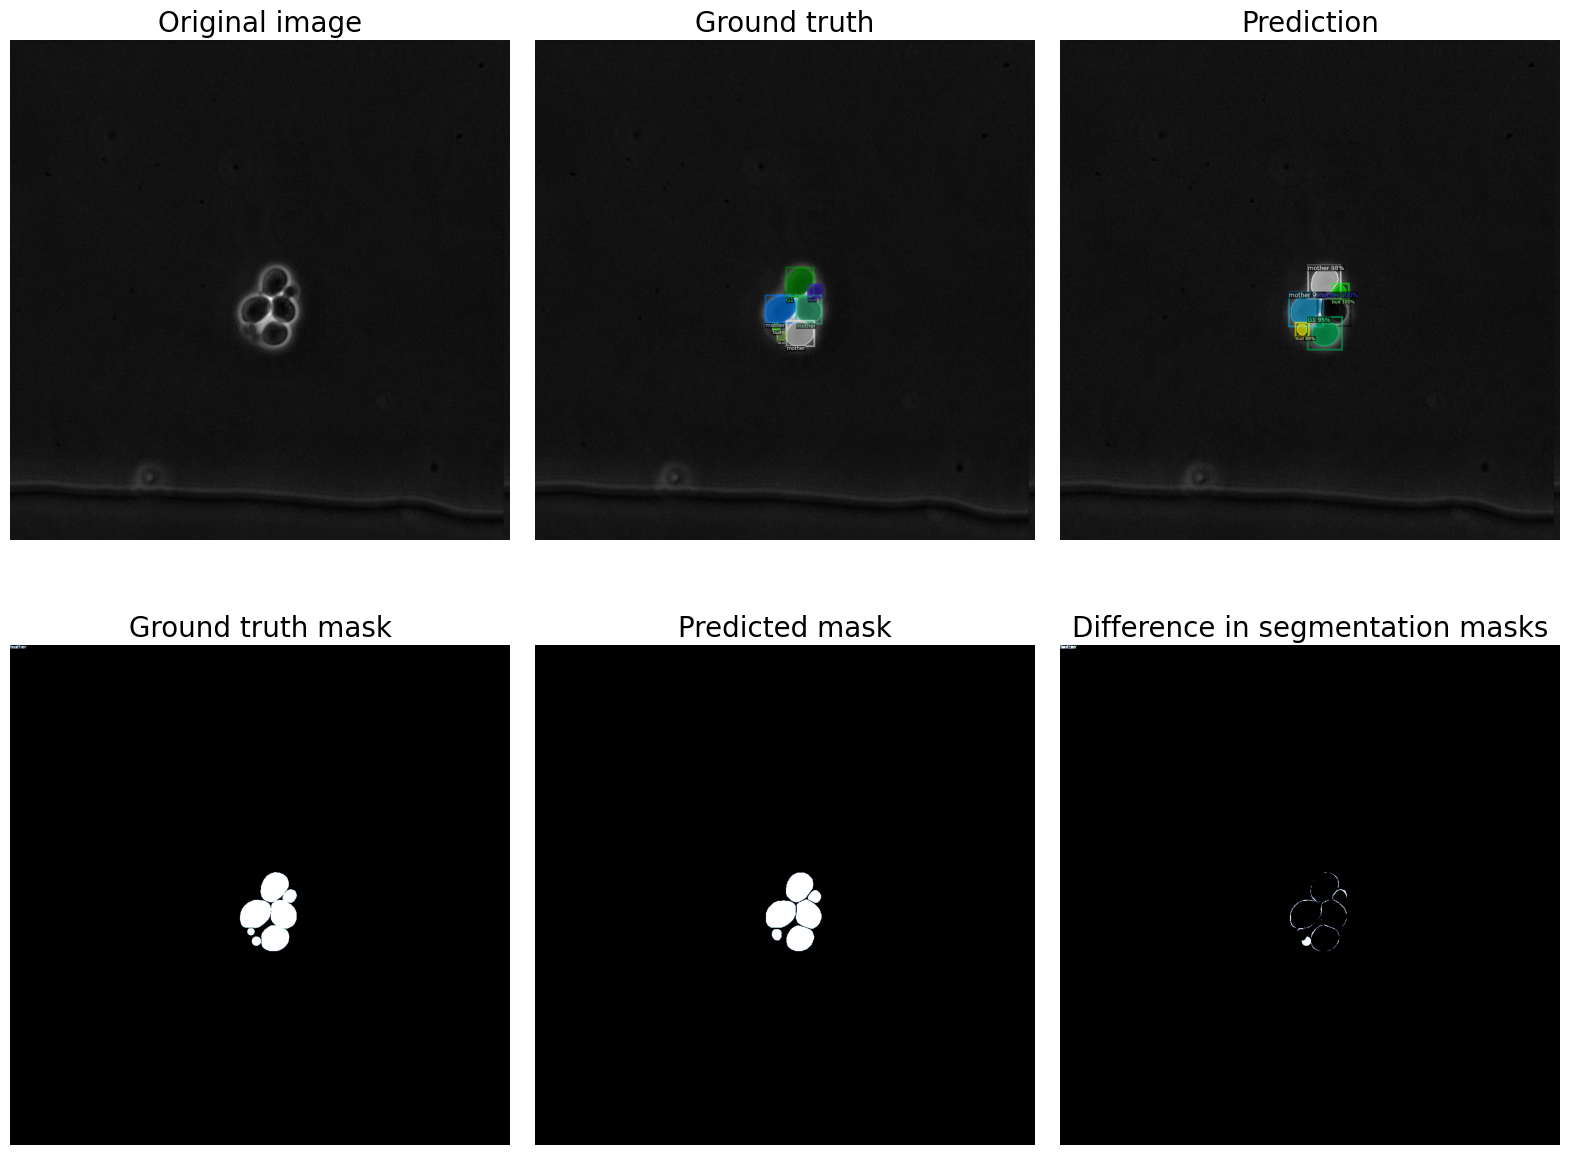

In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
for record in df.head().values:
    image_id = record[0]
    segm_ap = record[1]
    print(f"{image_id} segm_ap: {segm_ap}")

    image_json = get_json_by_id(image_id, test_data)  

    plot_prediction(image_json, test_dataset_name, cfg, model_path=os.path.join(model_path, "best_model.pth"))

acdc_data2_kurt_306-3_0_20201028_pos_1_6 segm_ap: 100.0


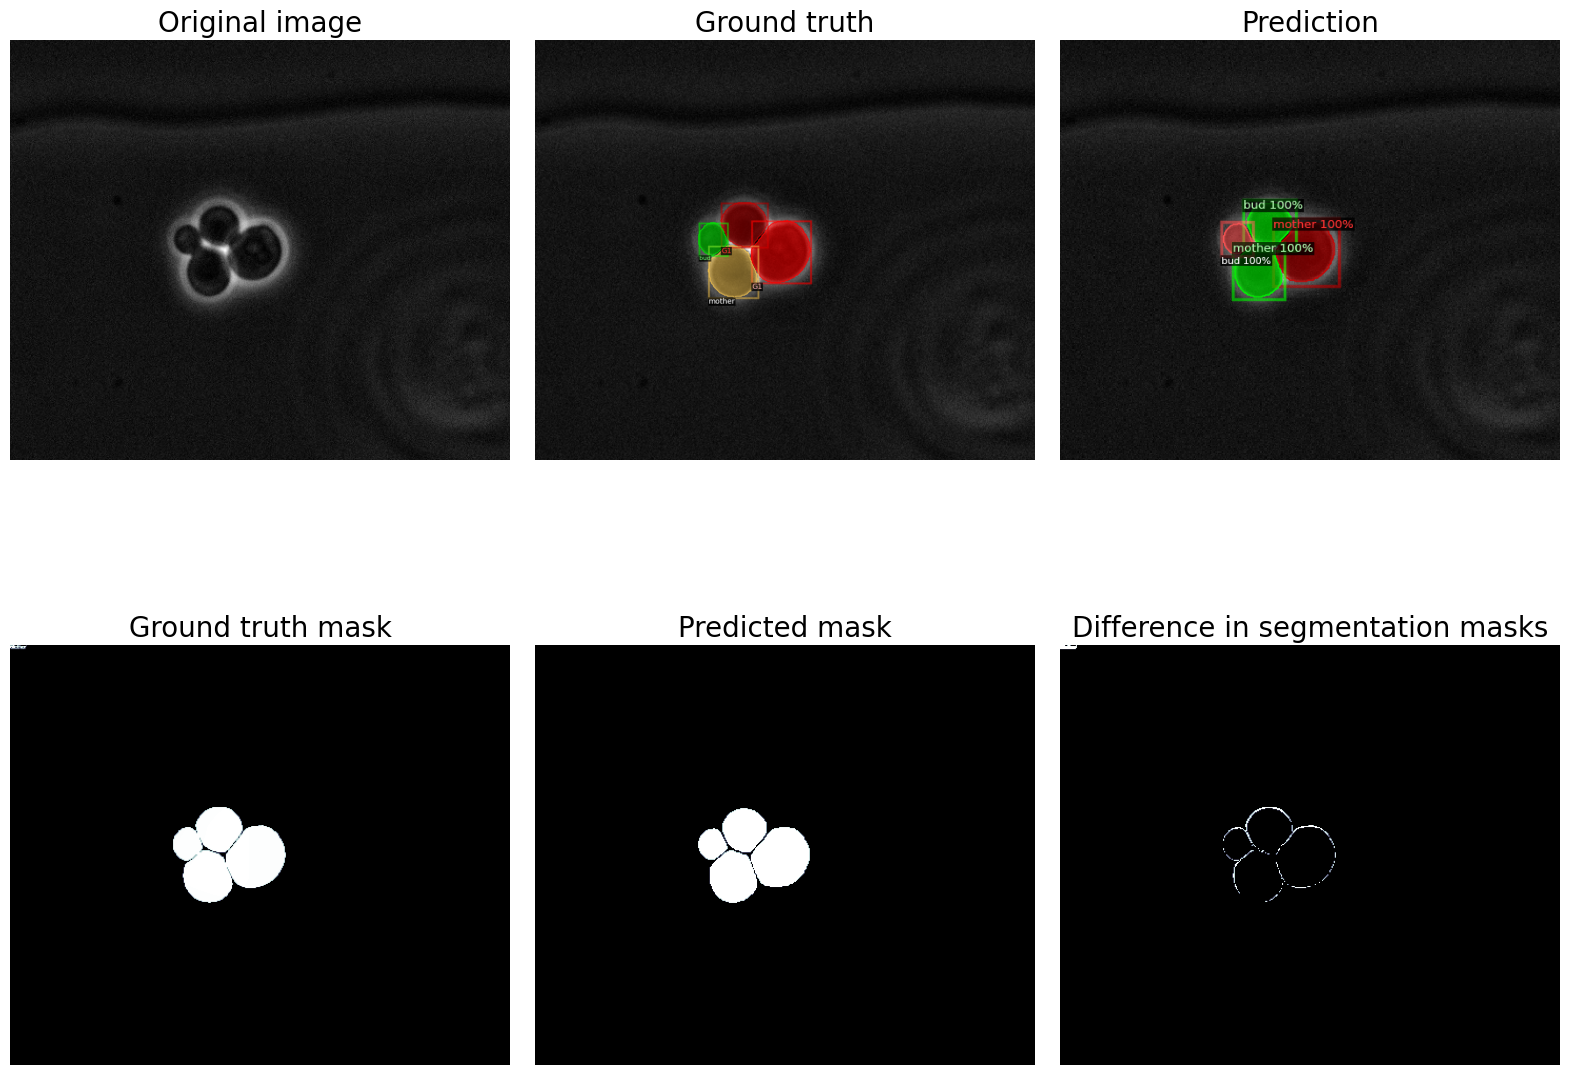

acdc_data2_kurt_306-3_0_20201028_pos_1_3 segm_ap: 100.0


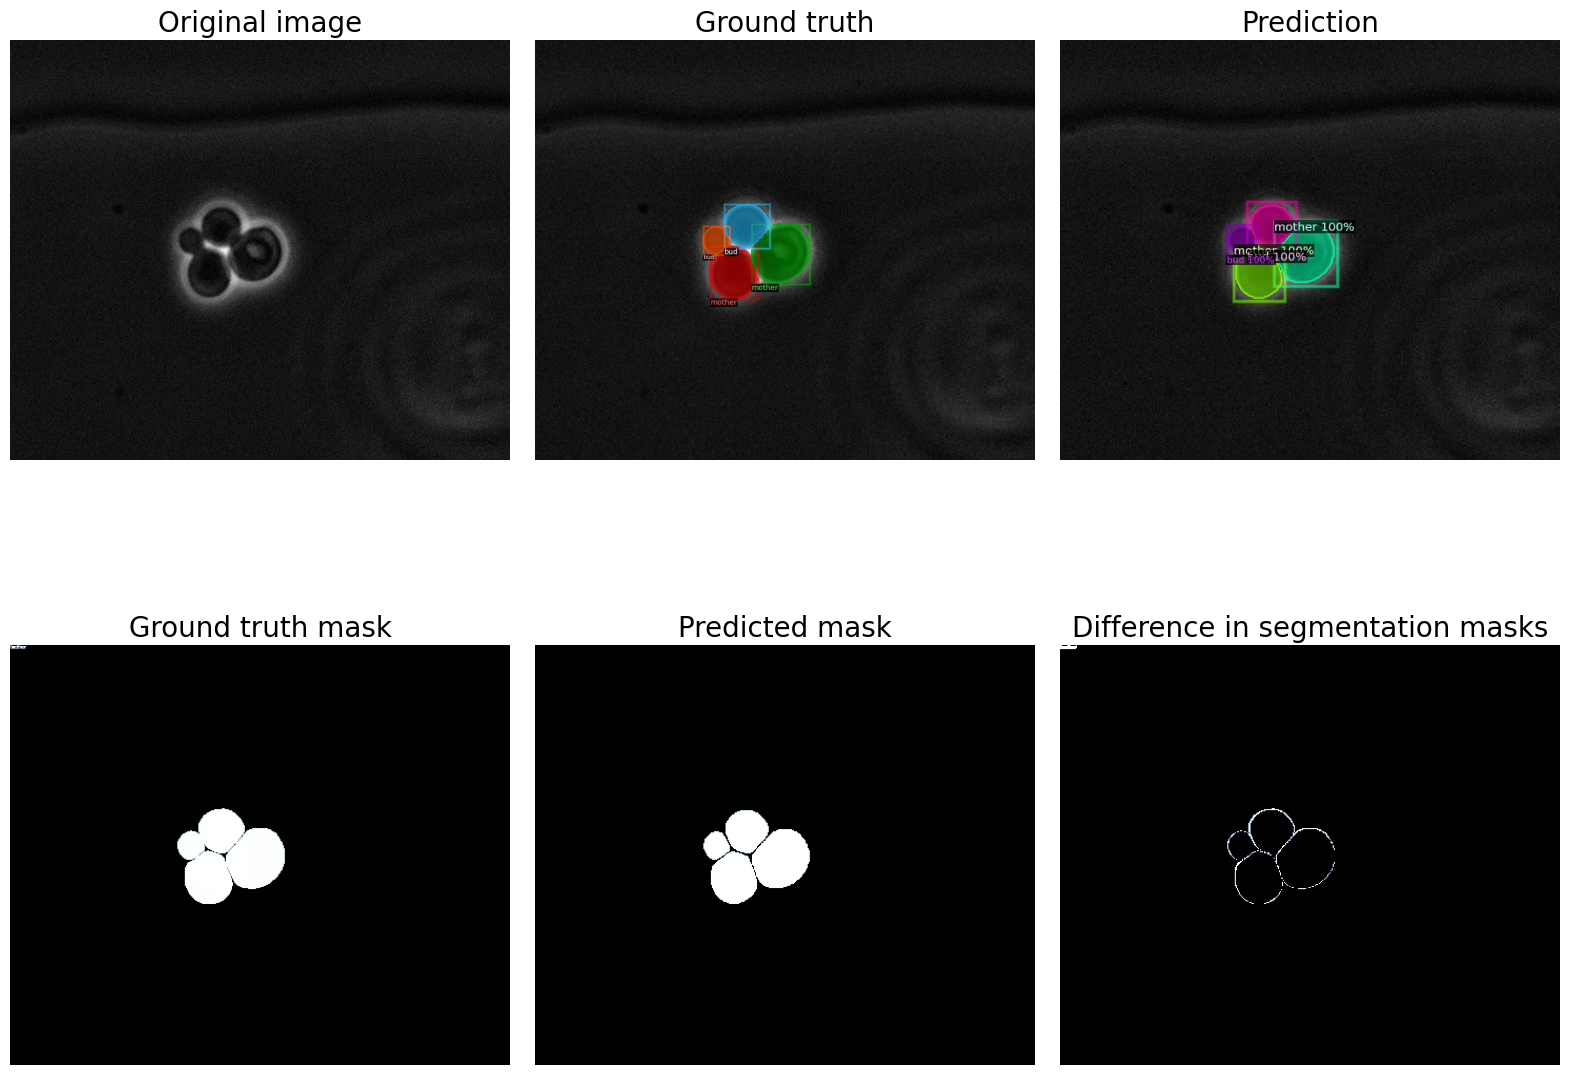

acdc_data2_F016_pos_3_72 segm_ap: 100.0


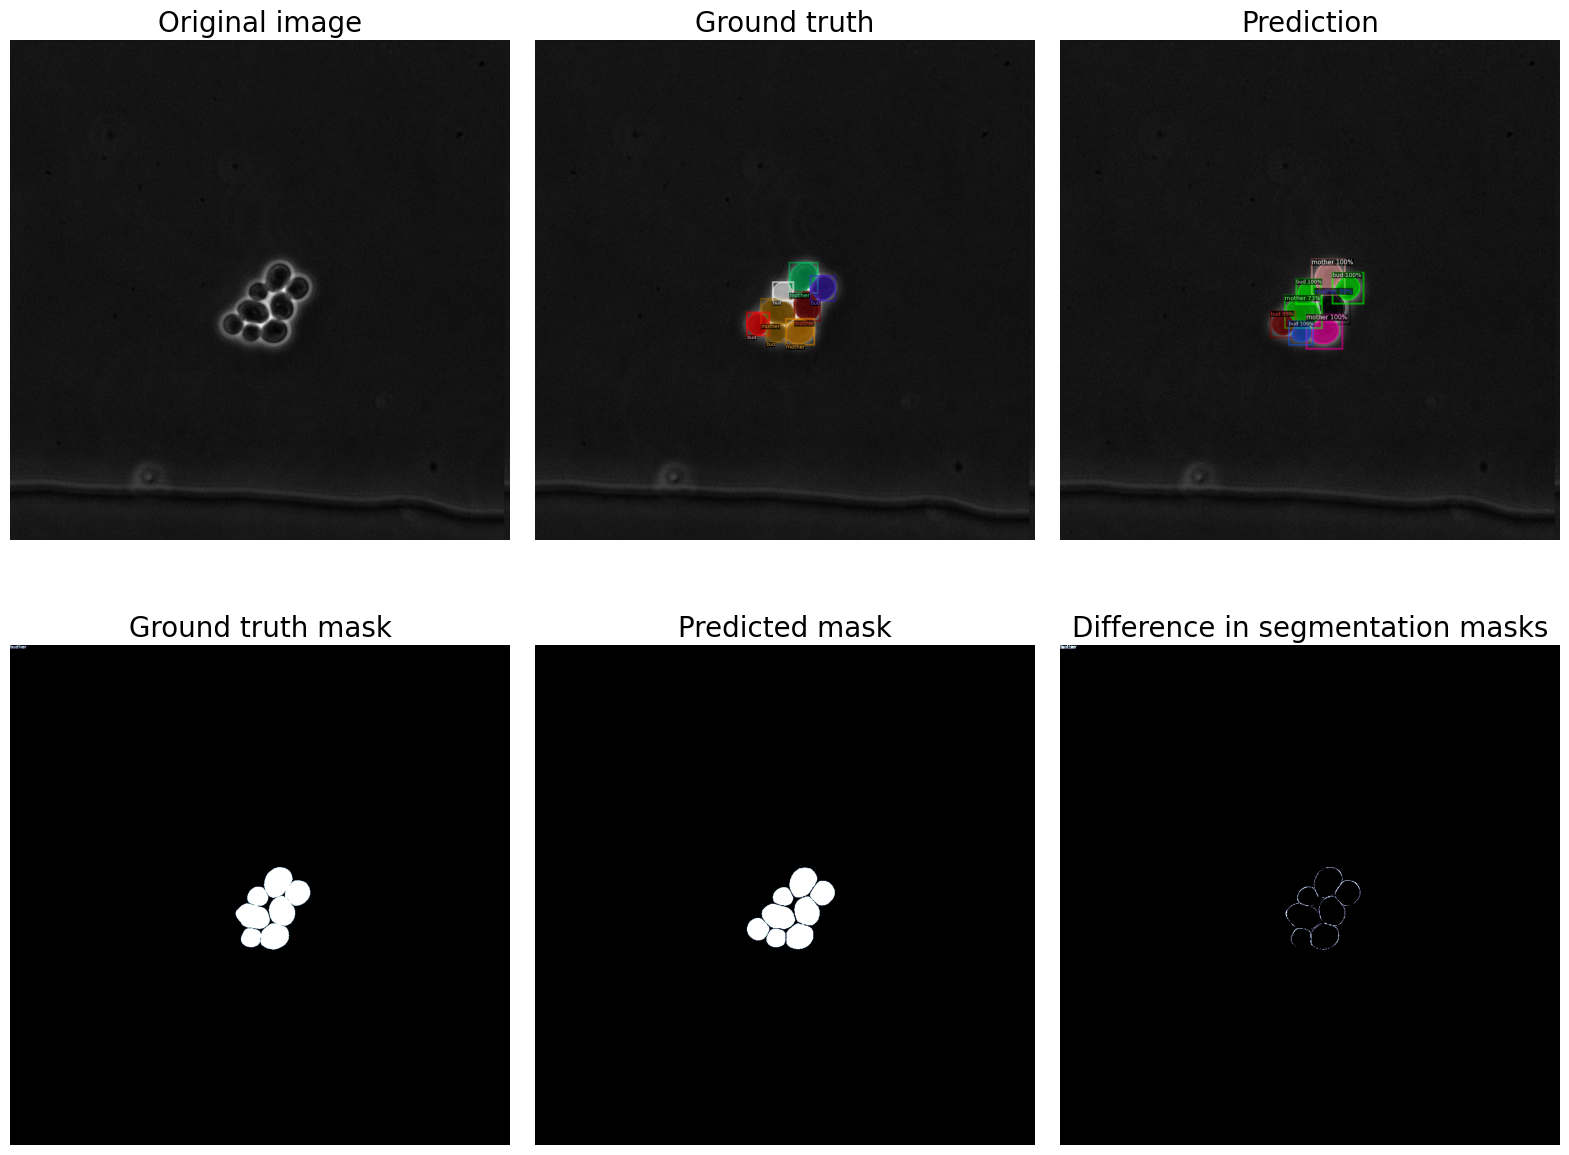

acdc_data3_20210722_pos_18_24 segm_ap: 100.0


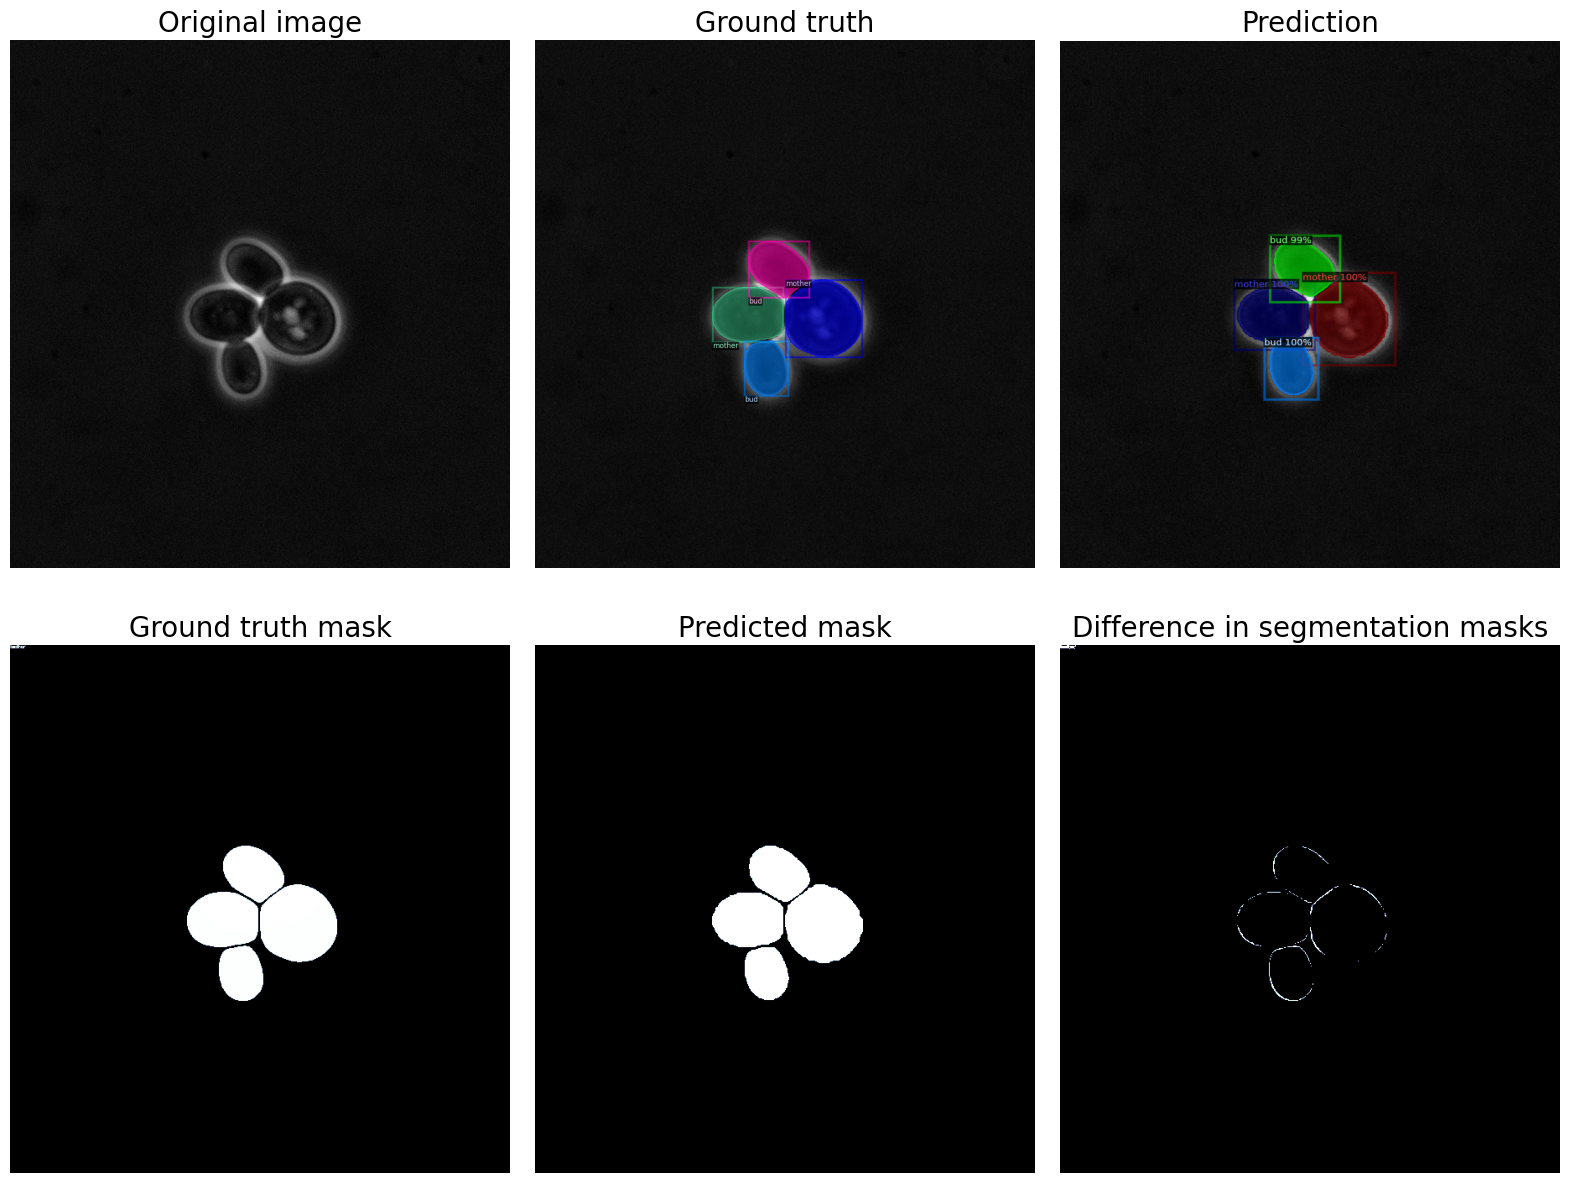

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0 segm_ap: 100.0


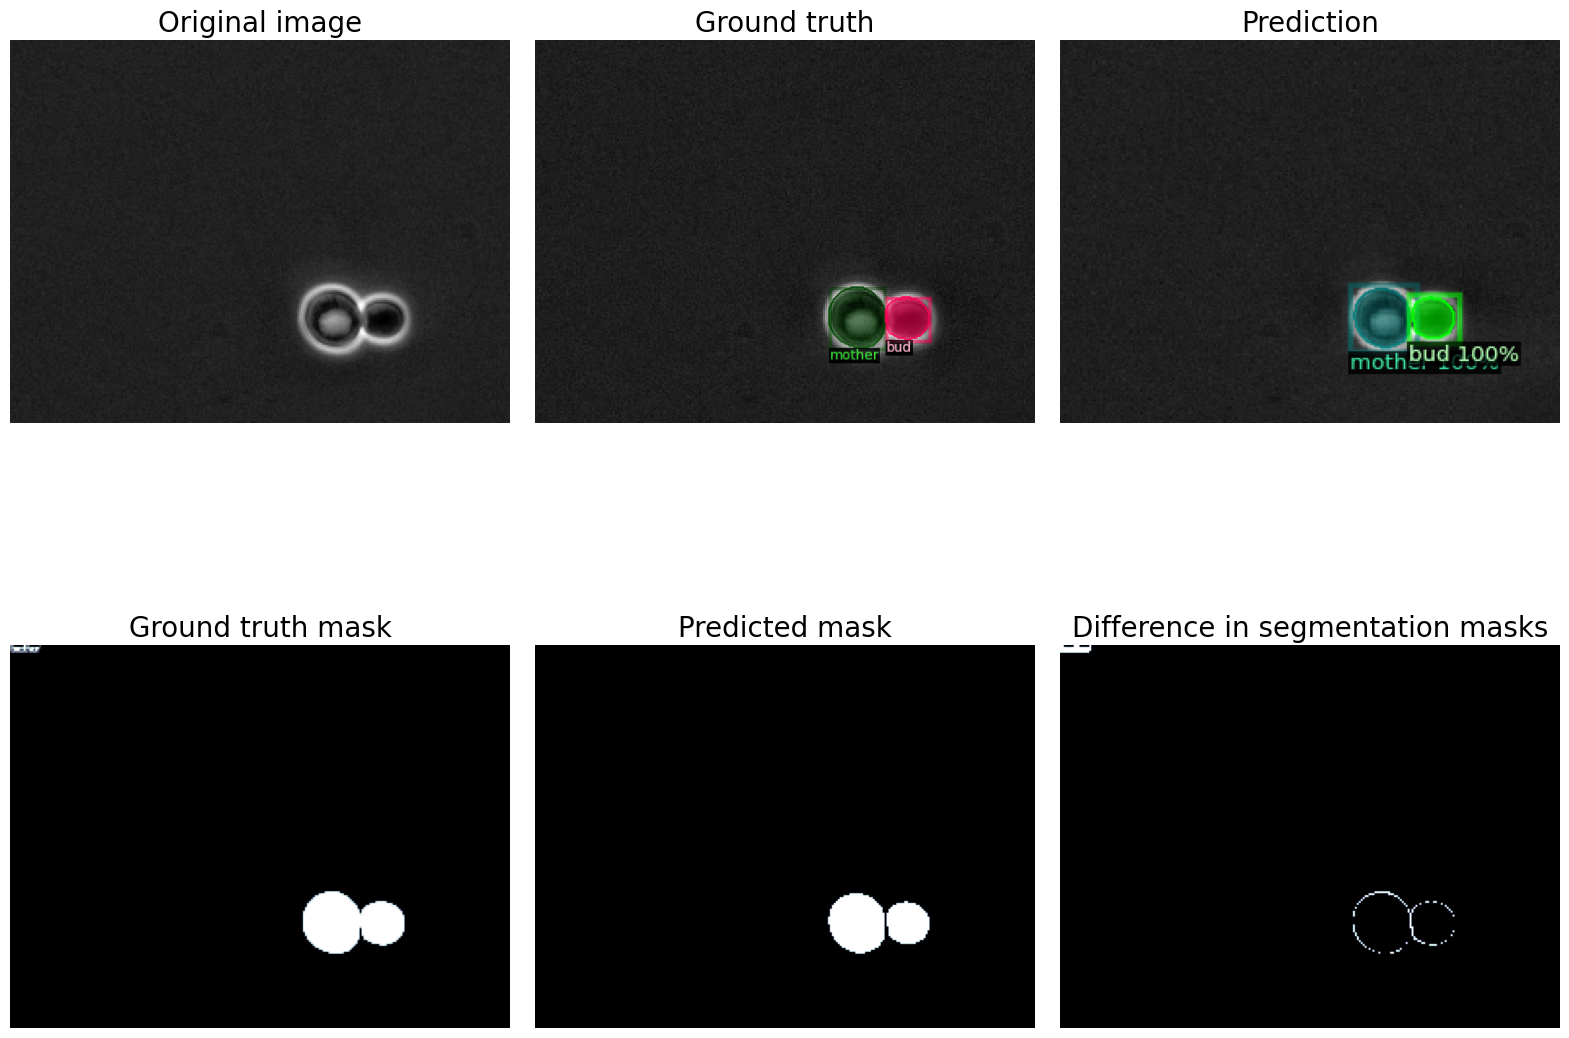

In [ ]:
for record in df.tail().values:
    image_id = record[0]
    segm_ap = record[1]
    print(f"{image_id} segm_ap: {segm_ap}")

    image_json = get_json_by_id(image_id, test_data)  

    plot_prediction(image_json, test_dataset_name, cfg, model_path=os.path.join(model_path, "best_model.pth"))
    
    
    

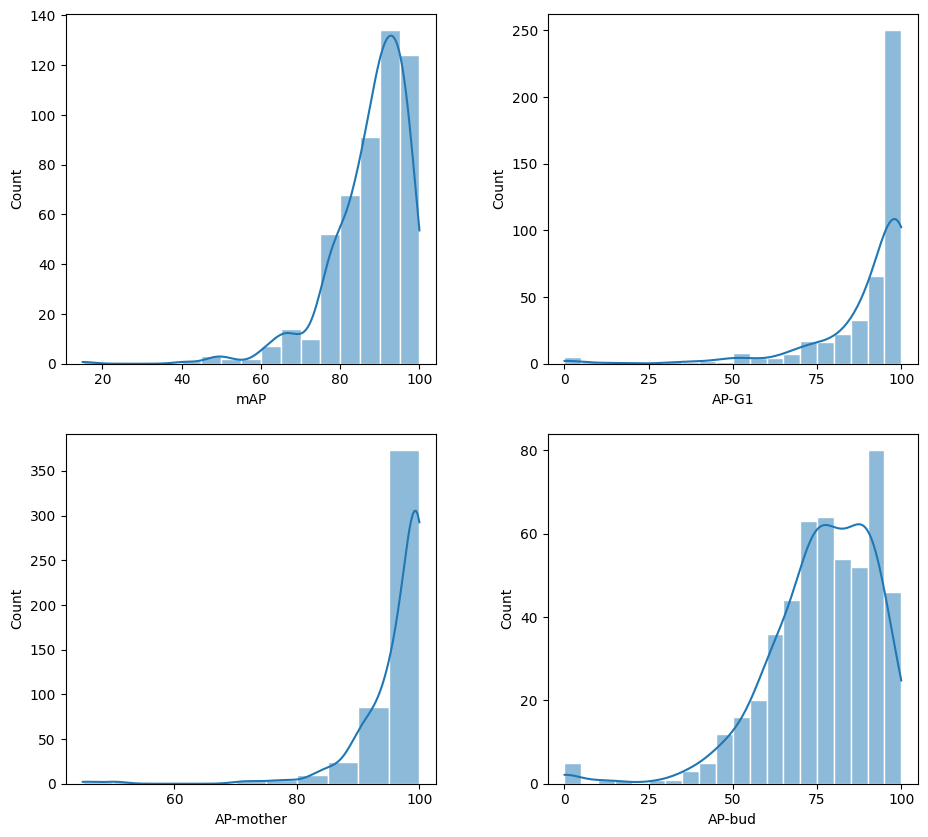

In [16]:

df["mAP"] = df["segm_ap"] 

fig, axs = plt.subplots(2, 2, figsize=(11, 10))
sns.set(font_scale=1.4)
sns.histplot(data=df, x="mAP", label="mAP", kde=True, ax=axs[0, 0], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-G1", label="AP-G1", kde=True, ax=axs[0, 1], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-mother", label="AP-mother", kde=True, ax=axs[1, 0], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-bud", label="AP-bud", kde=True, ax=axs[1, 1], stat="count", binwidth=5)
fig.subplots_adjust(wspace=0.3)

In [17]:
df

image_id     segm_ap  \
92                            acdc_data2_F016_pos_3_18   15.000000   
120                           acdc_data2_F016_pos_3_93   40.798366   
401                        acdc_data3_20211029_pos_1_9   47.970297   
130          acdc_data2_kurt_306-3_0_20201028_pos_1_12   48.481848   
276                       acdc_data3_20210722_pos_2_21   48.706271   
..                                                 ...         ...   
392                       acdc_data3_20211029_pos_1_63  100.000000   
398                       acdc_data3_20211029_pos_1_81  100.000000   
399                       acdc_data3_20211029_pos_1_84  100.000000   
101                           acdc_data2_F016_pos_3_42  100.000000   
0    TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0  100.000000   

          AP-G1   AP-mother      AP-bud         mAP  
92     0.000000   45.000000    0.000000   15.000000  
120   76.072607   45.841584    0.480905   40.798366  
401         NaN   50.495050   45.445545   47.970297  
130    0.000000  100.000000   45.445545   48.481848  
276   16.831683   82.554455   46.732673   48.706271  
..          ...         ...         ...         ...  
392  100.000000  100.000000  100.000000  100.000000  
398  100.000000  100.000000  100.000000  100.000000  
399  100.000000  100.000000  100.000000  100.000000  
101         NaN  100.000000  100.000000  100.000000  
0           NaN  100.000000  100.000000  100.000000  

[509 rows x 6 columns]

In [18]:

df["num_objects"] = df["image_id"].map(lambda x: len(get_json_by_id(x, test_data)['annotations']))



In [19]:
df

image_id     segm_ap  \
92                            acdc_data2_F016_pos_3_18   15.000000   
120                           acdc_data2_F016_pos_3_93   40.798366   
401                        acdc_data3_20211029_pos_1_9   47.970297   
130          acdc_data2_kurt_306-3_0_20201028_pos_1_12   48.481848   
276                       acdc_data3_20210722_pos_2_21   48.706271   
..                                                 ...         ...   
392                       acdc_data3_20211029_pos_1_63  100.000000   
398                       acdc_data3_20211029_pos_1_81  100.000000   
399                       acdc_data3_20211029_pos_1_84  100.000000   
101                           acdc_data2_F016_pos_3_42  100.000000   
0    TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0  100.000000   

          AP-G1   AP-mother      AP-bud         mAP  num_objects  
92     0.000000   45.000000    0.000000   15.000000            3  
120   76.072607   45.841584    0.480905   40.798366           11  
401         NaN   50.495050   45.445545   47.970297            4  
130    0.000000  100.000000   45.445545   48.481848            5  
276   16.831683   82.554455   46.732673   48.706271            9  
..          ...         ...         ...         ...          ...  
392  100.000000  100.000000  100.000000  100.000000            6  
398  100.000000  100.000000  100.000000  100.000000            7  
399  100.000000  100.000000  100.000000  100.000000            7  
101         NaN  100.000000  100.000000  100.000000            4  
0           NaN  100.000000  100.000000  100.000000            2  

[509 rows x 7 columns]

In [20]:
bins = range(0,61,10)
df['Number of Objects'] = pd.cut(df['num_objects'], bins)

In [21]:


fig, axs = plt.subplots(1, 2, figsize=(11, 10))
sns.set(font_scale=1.4)
sns.histplot(data=df, x="mAP", label="mAP", kde=True, ax=axs[0, 0], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-G1", label="AP-G1", kde=True, ax=axs[0, 1], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-mother", label=best_model.pth"AP-mother", kde=True, ax=axs[1, 0], stat="count", binwidth=5)
sns.histplot(data=df, x="AP-bud", label="AP-bud", kde=True, ax=axs[1, 1], stat="count", binwidth=5)
fig.subplots_adjust(wspace=0.3)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3551528078.py, line 5)

In [ ]:
df.head()

image_id    segm_ap      AP-G1  AP-mother     AP-bud  \
92   acdc_data2_F016_pos_3_18  30.000000  45.000000  45.000000   0.000000   
120  acdc_data2_F016_pos_3_93  45.676240  76.072607  59.879774   1.076340   
119  acdc_data2_F016_pos_3_90  51.559406  94.678218  50.000000  10.000000   
121  acdc_data2_F016_pos_3_96  54.067157  33.333333  96.410891  32.457246   
108  acdc_data2_F016_pos_3_60  60.058306  50.000000  91.584158  38.590759   

           mAP  
92   30.000000  
120  45.676240  
119  51.559406  
121  54.067157  
108  60.058306

In [23]:
class_segm_ap_dict = [
    {
        "image_id": key,
        "AP": res[key]["segm"]["AP-G1"],
        "Class": "AP-G1",

    } for key in res.keys()
] + [
    {
        "image_id": key,
        "AP": res[key]["segm"]["AP-mother"],
        "Class": "AP-mother",
    } for key in res.keys()
] + [
    {
        "image_id": key,
        "AP": res[key]["segm"]["AP-bud"],
        "Class": "AP-bud",
    } for key in res.keys()
]
class_df = pd.DataFrame.from_records(class_segm_ap_dict)

<AxesSubplot: xlabel='AP', ylabel='Count'>

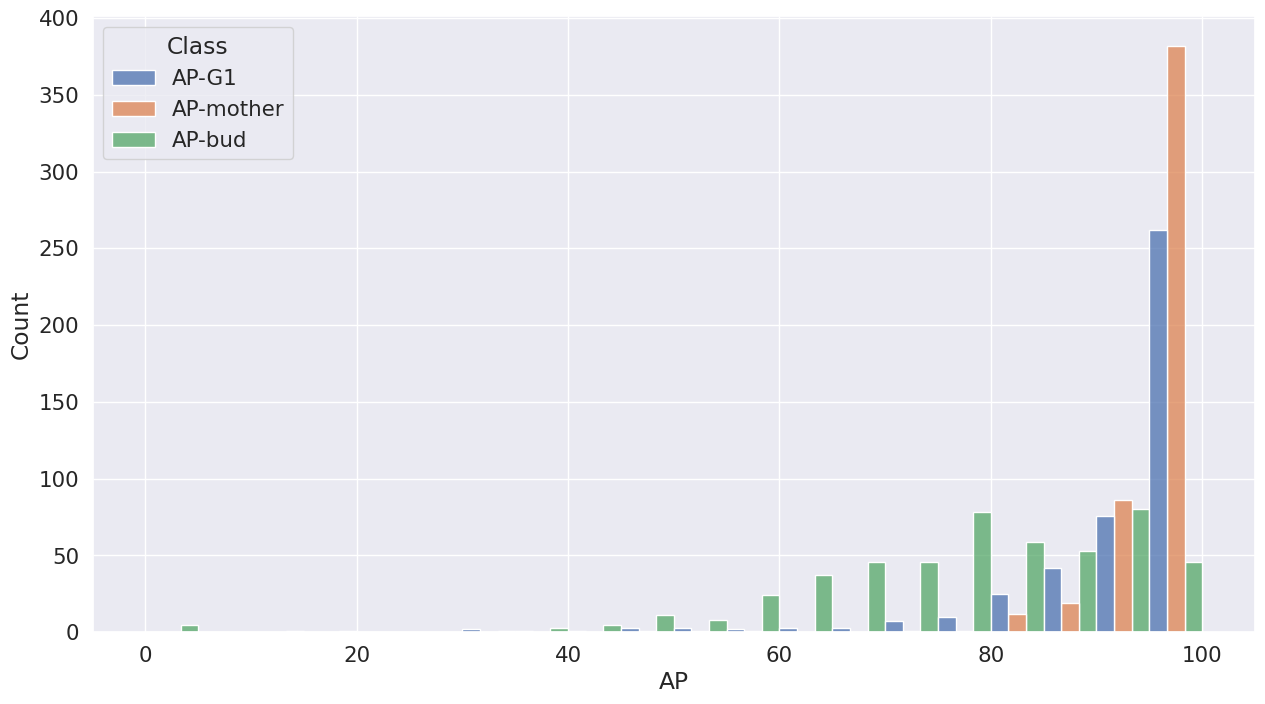

In [ ]:
#fig, axs = plt.subplots(1, 1, figsize=(11, 10))
fig = plt.figure(figsize=(15, 8))
sns.set(font_scale=1.4)
sns.histplot(data=class_df, x="AP", label="AP", kde=False, hue="Class", multiple="dodge",stat="count", binwidth=5)


<AxesSubplot: xlabel='AP', ylabel='Proportion'>

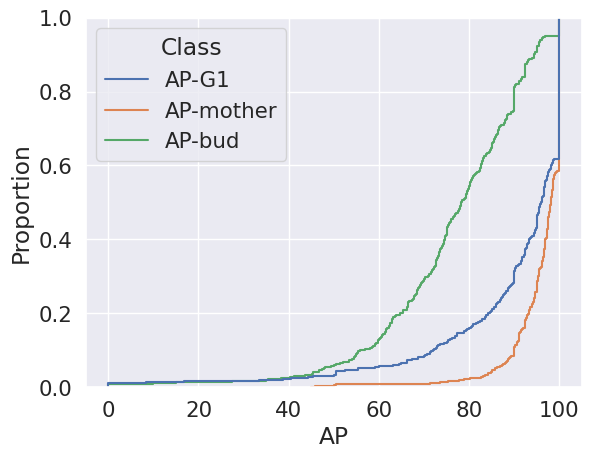

In [24]:
sns.ecdfplot(data=class_df, x="AP", label="AP", hue="Class")



In [53]:
print(class_df[class_df["Class"] == "AP-mother"].median())
print(class_df[class_df["Class"] == "AP-G1"].median())
print(class_df[class_df["Class"] == "AP-bud"].median())

print(class_df[class_df["Class"] == "AP-mother"].quantile(0.25))
print(class_df[class_df["Class"] == "AP-G1"].quantile(0.25))
print(class_df[class_df["Class"] == "AP-bud"].quantile(0.25))

AP    98.143564
dtype: float64
AP    96.11504
dtype: float64
AP    78.386964
dtype: float64
AP    94.606541
Name: 0.25, dtype: float64
AP    87.745757
Name: 0.25, dtype: float64
AP    68.182068
Name: 0.25, dtype: float64


/tmp/ipykernel_7541/4264968094.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(class_df[class_df["Class"] == "AP-mother"].median())
/tmp/ipykernel_7541/4264968094.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(class_df[class_df["Class"] == "AP-G1"].median())
/tmp/ipykernel_7541/4264968094.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns

In [45]:
DatasetCatalog

DatasetCatalog(registered datasets: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fi

In [22]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
model = load_model(cfg, os.path.join(model_path, "best_model.pth"))
evaluator = AccuracyEvaluator(test_dataset_name, cfg, False,output_dir="./" )
val_loader = build_detection_test_loader(cfg, test_dataset_name)

#Use the created predicted model in the previous step
res = inference_on_dataset(model, val_loader, evaluator)

TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_102
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_105
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_108
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_111
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_114
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_117
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_12
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_120
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_123
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_126
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_129
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_132
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_135
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_138
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_141
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_144
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_147
TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_15
TimeLapse_2D_MIA

In [16]:
res_df = pd.DataFrame.from_records(res)
print("precision:", len(res_df[res_df["detection_type"] == "tp"])/(len(res_df[res_df["detection_type"] == "fp"]) + len(res_df[res_df["detection_type"] == "tp"])))
print("recall:", len(res_df[res_df["detection_type"] == "tp"])/(len(res_df[res_df["detection_type"] == "fn"]) + len(res_df[res_df["detection_type"] == "tp"])))

precision: 0.7060270602706027
recall: 0.9912502878194797


In [25]:
CATEGORIES = [
    {
        "id": 0,
        "name": "G1",
        "supercategory": "Cell",
    },
    {
        "id": 1,
        "name": "mother",
        "supercategory": "Cell",
    },
    {
        "id": 2,
        "name": "bud",
        "supercategory": "Cell",
    },

]

res_df = pd.DataFrame.from_records(res)
print("precision:", len(res_df[res_df["detection_type"] == "tp"])/(len(res_df[res_df["detection_type"] == "fp"]) + len(res_df[res_df["detection_type"] == "tp"])))
print("recall:", len(res_df[res_df["detection_type"] == "tp"])/(len(res_df[res_df["detection_type"] == "fn"]) + len(res_df[res_df["detection_type"] == "tp"])))
print("mean iou", res_df["iou"].mean())

res_df["class_right"] = res_df["pred_class"] == res_df["true_class"]

print("classification:", sum(res_df["class_right"] )/len(res_df["class_right"]))

res_list = []

for c in res_df["true_class"].unique():
    if c == c:
        res_list.append({
            "Class": CATEGORIES[int(c)]["name"],
            "Detection recall": sum(res_df[res_df["true_class"] == c]["detected"])/len(res_df[res_df["true_class"] == c]["detected"]),
            "Classification recall": sum(res_df[res_df["true_class"] == c]["class_right"])/len(res_df[res_df["true_class"] == c]["class_right"]),
            "Classification precision":sum(res_df[res_df["pred_class"] == c]["class_right"])/len(res_df[res_df["pred_class"] == c]["class_right"]),
            "Mean mask IoU": res_df[res_df["pred_class"] == c]["iou"].mean(),
        })        

print(pd.DataFrame.from_records(res_list).to_latex(index=False))

precision: 0.9799346710219319
recall: 0.9670734515311996
mean iou 0.9318156278512114
classification: 0.8899300067735381
\begin{tabular}{lrrrr}
\toprule
 Class &  Detection recall &  Classification recall &  Classification precision &  Mean mask IoU \\
\midrule
mother &          0.983689 &               0.937265 &                  0.921085 &       0.960756 \\
   bud &          0.946675 &               0.930678 &                  0.938034 &       0.882571 \\
    G1 &          0.972294 &               0.834632 &                  0.890531 &       0.959529 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_15624/4010765554.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_records(res_list).to_latex(index=False))


In [32]:
print(res_df[res_df["detection_type"] == "fp"].groupby("pred_class").count().reset_index()[["pred_class","image_id"]])
print(res_df[res_df["detection_type"] == "fn"].groupby("true_class").count().reset_index()[["pred_class","image_id"]])

   pred_class  image_id
0         0.0        45
1         1.0        40
2         2.0        87
   pred_class  image_id
0           0        64
1           0        52
2           0       170


In [33]:
res_df[res_df["detection_type"] == "tp"]

image_id  object_id  \
0     TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0          0   
1     TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_5_0          1   
2     TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...          0   
3     TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...          1   
4     TimeLapse_2D_MIA_KC_htb1_mCitrine_labeled_pos_...          2   
...                                                 ...        ...   
8853                    acdc_data3_Yagya_SCD_WT_pos_6_9         13   
8854                    acdc_data3_Yagya_SCD_WT_pos_6_9         14   
8855                    acdc_data3_Yagya_SCD_WT_pos_6_9         15   
8856                    acdc_data3_Yagya_SCD_WT_pos_6_9         16   
8857                    acdc_data3_Yagya_SCD_WT_pos_6_9         17   

                                              pred_mask       iou  pred_class  \
0     [[[False, False, False, False, False, False, F...  0.981844         1.0   
1     [[[False, False, False, False, False, False, F...  0.959184         2.0   
2     [[[False, False, False, False, False, False, F...  0.970849         1.0   
3     [[[False, False, False, False, False, False, F...  0.970537         1.0   
4     [[[False, False, False, False, False, False, F...  0.982987         1.0   
...                                                 ...       ...         ...   
8853  [[[False, False, False, False, False, False, F...  0.958885         1.0   
8854  [[[False, False, False, False, False, False, F...  0.922144         2.0   
8855  [[[False, False, False, False, False, False, F...  0.957087         2.0   
8856  [[[False, False, False, False, False, False, F...  0.966292         2.0   
8857  [[[False, False, False, False, False, False, F...  0.855263         2.0   

      true_class  detected detection_type  class_right  
0            1.0      True             tp         True  
1            2.0      True             tp         True  
2            1.0      True             tp         True  
3            1.0      True             tp         True  
4            1.0      True             tp         True  
...          ...       ...            ...          ...  
8853         1.0      True             tp         True  
8854         2.0      True             tp         True  
8855         2.0      True             tp         True  
8856         2.0      True             tp         True  
8857         2.0      True             tp         True  

[8400 rows x 9 columns]

In [34]:
res_df.groupby(by=["true_class","pred_class"]).count()

image_id  object_id  pred_mask   iou  detected  \
true_class pred_class                                                   
0          0.0             1955       1955       1955  1955      1955   
           1.0              226        226        226   226       226   
           2.0              113        113        113   113       113   
1          0.0              168        168        168   168       168   
           1.0             3009       3009       3009  3009      3009   
           2.0                2          2          2     2         2   
2          0.0               51         51         51    51        51   
           1.0                6          6          6     6         6   
           2.0             3080       3080       3080  3080      3080   

                       class_right  
true_class pred_class               
0          0.0                1955  
           1.0                 226  
           2.0                 113  
1          0.0                 168  
           1.0                3009  
           2.0                   2  
2          0.0                  51  
           1.0                   6  
           2.0                3080

In [46]:
res_df = res_df.dropna()

res_df['true_class_name'] = res_df.apply(lambda row: CATEGORIES[int(row['true_class'])]["name"],axis=1)
res_df['pred_class_name'] = res_df.apply(lambda row: CATEGORIES[int(row['pred_class'])]["name"],axis=1)


print(pd.crosstab(res_df['true_class_name'], res_df['pred_class_name'], rownames=['GT class'], colnames=['Predicted Class']).to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
Predicted Class &    G1 &   bud &  mother \\
GT class &       &       &         \\
\midrule
G1       &  2201 &   294 &     891 \\
bud      &   247 &  3494 &      18 \\
mother   &   726 &    17 &    3168 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_7541/1335671770.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.crosstab(res_df['true_class_name'], res_df['pred_class_name'], rownames=['GT class'], colnames=['Predicted Class']).to_latex(index=True))
